In [1]:
import sys
import tensorflow as tf
tf.config.threading.set_inter_op_parallelism_threads(0)
tf.config.threading.set_intra_op_parallelism_threads(0)
tf.config.experimental.enable_mlir_bridge()

tf.config.thallow_soft_placement=True


import pymc4 as pm
import arviz as az
import tensorflow_probability as tfp

from tensorflow.keras.backend import sum as tf_sum

import numpy as np

import logging

import matplotlib.pyplot as plt

log = logging.getLogger(__name__)


In [2]:

physical_devices = tf.config.list_physical_devices('CPU')
config = tf.config.get_logical_device_configuration(physical_devices[0])
print(physical_devices)
print(config)

print(tf.config.experimental.get_device_policy())

print(tf.config.threading.get_inter_op_parallelism_threads())
print(tf.config.threading.get_intra_op_parallelism_threads())
print(tf.config.optimizer.get_experimental_options())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
None
silent
0
0
{'disable_model_pruning': False, 'disable_meta_optimizer': False}


In [3]:
from pymc4.distributions.transforms import Transform, JacobianPreference
from tensorflow_probability import bijectors as tfb



class transform_Log(Transform):
    name = "log"
    JacobianPreference = JacobianPreference.Backward

    def __init__(self,reinterpreted_batch_ndims):
        # NOTE: We actually need the inverse to match PyMC3, do we?
        self._transform = tfb.Exp()
        self._reinterpreted_batch_ndims = reinterpreted_batch_ndims

    def forward(self, x):
        return self._transform.inverse(x)

    def inverse(self, z):
        return self._transform.forward(z)

    def forward_log_det_jacobian(self, x):
        return self._transform.inverse_log_det_jacobian(x, self._transform.inverse_min_event_ndims + self._reinterpreted_batch_ndims)

    def inverse_log_det_jacobian(self, z):
        return self._transform.forward_log_det_jacobian(z, self._transform.forward_min_event_ndims + self._reinterpreted_batch_ndims)

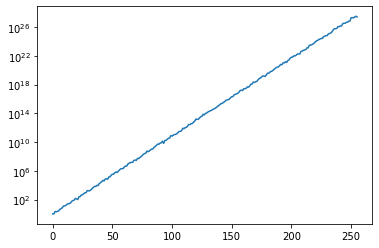

In [4]:
# Generate Test data: exponential
DTYPE = tf.float32
data = tf.math.exp(tf.range(0,64,.25,dtype=DTYPE))
data *= tfp.distributions.LogNormal(loc=tf.cast(0,DTYPE),scale=.2).sample(data.shape[0])

plt.semilogy(data)

In [10]:

@tf.function(autograph=True,experimental_compile=True)
def f0(d,b):
    r = tf.range(0,d.shape[-1],dtype=DTYPE)
    est = tf.math.exp(b*r)
    est = tf.expand_dims(est,-1)
    return est

@tf.function(autograph=True)
def f1(d,b):
    a_size = d.shape[-1]
    e_size = b.shape#[None,b.shape[-1]]
    print("func_input",d.shape,b.shape,"array",a_size,"x",e_size,"type",d.dtype,b.dtype)
    
    # Setup TensorArray and run loop
    ta = tf.TensorArray(DTYPE, size=a_size, dynamic_size=False , element_shape=e_size )
    ta = ta.write(0,tf.ones(b.shape,dtype=DTYPE))
    
    for i in tf.range(d.shape[-1]-1):
        ta = ta.write(i+1, ta.read(i)*b)
    r = ta.stack()
    
#    c = tf.less(tf.rank(b),2)
 #   r = tf.cond(c, lambda : r, lambda : tf.transpose(r,tf.concat([[1,0],tf.range(2,tf.rank(r))],0) )  )
    if len(r.shape) == 3:
        r = tf.transpose(r,perm=[1,0,2] )
    
    print("func_result",r.shape,r.dtype)
    
    return r

@tf.function(autograph=True)
def f1_mod(d,b):
    a_size = d.shape[-1]
    e_size = b.shape#[None,b.shape[-1]]
    print("func_input",d.shape,b.shape,"array",a_size,"x",e_size,"type",d.dtype,b.dtype)
    
    # Setup TensorArray and run loop
    ta = tf.TensorArray(DTYPE, size=a_size, dynamic_size=False , element_shape=e_size )
    ta = ta.write(0,tf.ones(b.shape,dtype=DTYPE))
    
#    for i in tf.range(d.shape[-1]-1):
 #       ta = ta.write(i+1, ta.read(i)*b)
 
    _,ta = tf.while_loop(lambda i,*_:i <d.shape[-1]-1,
                         lambda i,a : (i+1,ta.write(i+1,ta.read(i)*b)),
                         (0,ta),
                         maximum_iterations=d.shape[-1]-1
                        )

    r = ta.stack()
#    c = tf.less(tf.rank(b),2)
 #   r = tf.cond(c, lambda : r, lambda : tf.transpose(r,tf.concat([[1,0],tf.range(2,tf.rank(r))],0) )  )
    if len(r.shape) == 3:
        r = tf.transpose(r,perm=[1,0,2] )
    
    print("func_result",r.shape,r.dtype)
    
    return r


@tf.function(autograph=True)
def f2(d,b):

    r = tf.scan(lambda a,x : a*b ,d, tf.ones(b.shape,dtype=DTYPE))
 
 #   c = tf.less(tf.rank(b),2)
#    r = tf.cond(c, lambda : r, lambda : tf.transpose(r,tf.concat([[1,0],tf.range(2,tf.rank(r))],0) )  )

    if len(r.shape) == 3:
        r = tf.transpose(r,perm=[1,0,2])

    return r

@tf.function(autograph=True)
def f3(d,b):

    r = tf.scan(lambda a,x : a*b ,d, tf.ones(b.shape,dtype=DTYPE))
 
 #   c = tf.less(tf.rank(b),2)
#    r = tf.cond(c, lambda : r, lambda : tf.transpose(r,tf.concat([[1,0],tf.range(2,tf.rank(r))],0) )  )

    if len(r.shape) == 3:
        r = tf.transpose(r,perm=[1,0,2])

    return r

@pm.model
def test_model(data):
    print("\n - - - - ")
    a = yield pm.LogNormal(name="a",
                           loc=tf.math.log(tf.ones(1,dtype=DTYPE)*2),
                           scale=.5,
                           conditionally_independent=True,
                           reinterpreted_batch_ndims=1,
#                           event_stack=0,
                           transform=transform_Log(reinterpreted_batch_ndims=1)
                          )
    print("a",a.shape,a.dtype)
    
    # Fit an explicit exponential 
#    est = f0(data,a)
    
    # Fit exponete
 #   est = f1(data,a)
#    est = f1_mod(data,a)

    est = f2(data,a)
    
    # The Rest:
    est_d = yield pm.Deterministic("est",est)

    data = tf.expand_dims(data,-1)
    print("observed",data.shape,data.dtype)
    
    like = yield pm.StudentT(name="like",
                             loc=est,
                             observed = data,
                             reinterpreted_batch_ndims=2,
                             scale=1,df=4
                            )
    print("like",like.shape,like.dtype)
    
%time trace = pm.sample(test_model(data), num_samples=1024, burn_in=256, num_chains=16,xla=True,use_auto_batching=False)




 - - - - 
a (1,) <dtype: 'float32'>
observed (256, 1) <dtype: 'float32'>
like (256, 1) <dtype: 'float32'>

 - - - - 
a (16, 1) <dtype: 'float32'>
observed (256, 1) <dtype: 'float32'>
like (16, 256, 1) <dtype: 'float32'>

 - - - - 
a (16, 1) <dtype: 'float32'>
observed (256, 1) <dtype: 'float32'>
like (16, 256, 1) <dtype: 'float32'>
CPU times: user 1min 16s, sys: 24.3 s, total: 1min 41s
Wall time: 37.9 s


In [ ]:
# Benchmark: (intra and inter = 0 --> system dicides)
# f2 128 points , (512+128)*  4 chains (   xla) :    4.88 s CPU,  4.9  s  wall
#               , (512+128)*  4 chains (no xla) :  1:07 min CPU,   56  s  wall
#               , (512+128)* 16 chains (   xla) :    6.37 s CPU,  5.75 s  wall
#               , (512+128)* 16 chains (no xla) :  6:09 min CPU, 6:18 min wall
#               , (512+128)*256 chains (   xla) :    51.2 s CPU,  25.5 s  wall
#               , (512+128)*256 chains (   xla) :    55.7 s CPU,  28.8 s  wall #2
#               , (512+128)*512 chains (   xla) :  2:49 min CPU, 1:13 min wall
# f2 256 points , (512+128)*512 chains (   xla) :  2:09 min CPU,  58.2 s  wall
# f1_mod        , (512+128)*512 chains (   xla) :  3:57 min CPU, 3:00 min wall
# f2            , ( 2k+128)* 1k chains (   xla) : 14:59 min CPU, 5:45 min wall
# f2            , ( 2k+128)* 1k chains (   xla) : 13:58 min CPU, 5:19 min wall
# f1_mo         , ( 2k+128)* 1k chains (   xla) : 25:38 min CPU,17:07 min wall

# f2            , ( 4k+128)* 1k chains (   xla) : 24:34 min CPU, 8:59 min wall ~7GB
# f2            , ( 2k+128)* 1k chains (   xla) : 19:57 min CPU, 7:13 min wall  8/8
# f2            , ( 2k+128)* 1k chains (   xla) :  7:50 min CPU, 3:18 min wall  16/16 ~7GB
# f2            , ( 4k+128)* 1k chains (   xla) : 11:20 min CPU, 4:50 min wall  16/16 ~7GB


# f1 128 points , (512+128)* 32 chains (no xla) : 15:04 min CPU,10:33 min wall
# f2 128 points , (512+128)* 32 chains (no xla) :  8:16 min CPU, 7:13 min wall
# f2 128 points , (512+128)* 32 chains (no xla) :  7:33 min CPU, 6:38 min wall

# f1 256 points , (512+128)* 32 chains (no xla) :  9:44 min CPU, 6:05 min wall
# f1 256 points , (512+128)* 64 chains (no xla) : 10:56 min CPU, 6:48 min wall
# f1 256 points , (512+128)*128 chains (no xla) : 16:05 min CPU,10:08 min wall
# f2 256 points , (512+128)* 64 chains (no xla) :  6:11 min CPU, 5:34 min wall
# f2 256 points , (512+128)*128 chains (no xla) : 16:22 min CPU,14:17 min wall
# f2 256 points , (512+128)*128 chains (   xla) :    24.8 s CPU,  15.5 s  wall
#f1m 256 points , (512+128)*128 chains (   xla) :    54.7 s CPU,  58.7 s  wall



In [ ]:
a = trace.posterior["test_model/a"].data
print("a=",np.mean(a,axis=(0,1)))
est = trace.posterior["test_model/est"]
print(est.shape)


plt.semilogy(np.mean(est,axis=(0,1)))
plt.semilogy(data,label="data")
plt.legend()

trace

In [ ]:
_ = az.plot_trace(trace,var_names=["test_model/a"])

In [ ]:
tf.TensorShape([])

In [ ]:
import tensorflow as tf

a = tf.add(1, 2, name="Add_these_numbers")
b = tf.multiply(a, 3)
c = tf.add(4, 5, name="And_These_ones")
d = tf.multiply(c, 6, name="Multiply_these_numbers")
e = tf.multiply(4, 5, name="B_add")
#f = tf.math.div(c, 6, name="B_mul")
g = tf.add(b, d)
h = tf.multiply(g, d)



In [ ]:
print(data)


@tf.function()
def generator(d):
    
    k = tf.TensorArray( size=0, dynamic_size=True, dtype=tf.float32)
#    i0 = tf.math.exp(tf.range(-16,0,dtype=tf.float32))
    k = k.write(0,[1])
    
    @tf.function()
    def body(i, l):
        x,a = l # unpack
        ta = ta.write(i+1,ta.read(i)+1)
        return (i+1, (x,a))

    
    
    init = (0, (d,k))
    condition = lambda i, _: i < d.shape[-1]
    
    (i_final, jk_final) = tf.while_loop(condition, body, init)

    
    return k.stack()
   # return tf.stack(k)

print("output")

r = generator(data)
print(r)


In [ ]:

@tf.function
def f(x):
    ta = tf.TensorArray(tf.int32, size=0, dynamic_size=True)
    ta = ta.write(0,1)
    for i in tf.range(x):
        tf.print(ta.read(i))
        ta = ta.write(i+1, ta.read(i)*2)
    return ta.stack()

f(10)


In [ ]:
@tf.function()
def f(d,b):
    ta = tf.TensorArray(tf.float32, size=d.shape[-1]+1, dynamic_size=False)
    ta = ta.write(0,1)
    for i in tf.range(d.shape[-1]):
        ta = ta.write(i+1, ta.read(i)*b)
#    return tf.slice(ta.stack(),[1],size=[d.shape[0]])
    return ta.stack()[...,1:]


#est = f( tf.slice(data,begin=[0],size=[64]), .25 )
est = f(data[:-1],.25)
    
print(est)
print(data)

In [ ]:
@tf.function(autograph=False)
def test(l,x):
    last,a = l
#    tf.print(last)
    return [last*a,a]




# exponential using scan-function
r = tf.scan(test,
            tf.range(8,dtype=tf.float32),
            [tf.ones(1,dtype=tf.float32),tf.constant(1.19,dtype=tf.float32)],
            parallel_iterations=1
           )


tf.print(tf.reshape(r[0],[r[0].shape[0]]))

# exponential using while-function

print(data)
print(r)
tf.GradientTape(r,0)

In [ ]:
a = tf.cast([[[1],[2],[3],[4]]],tf.int32)
tf.repeat(a,4,axis=0)